<a href="https://colab.research.google.com/github/tferdous17/CSC467_Module3Assignment/blob/main/csc467_mod_3_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from skimage import io as io_url

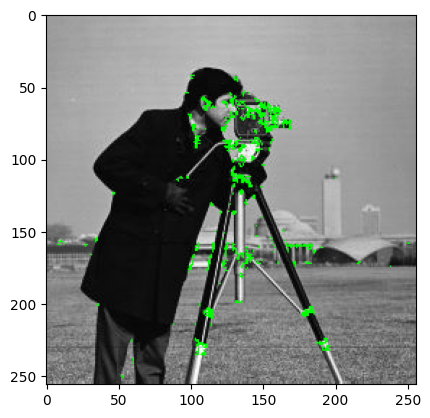

In [31]:
# A) Harris Corner Detector [30%]

url = "https://raw.githubusercontent.com/tferdous17/CSC467_Module3Assignment/main/cameraman.jpg"
img = io_url.imread(url)
# plt.imshow(img)

# img already grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

# 2. Compute image gradients using cv2.Sobel.
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

# 3. Compute the Harris response using cv2.cornerHarris.
harris_res = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# 4. Apply non-maximum suppression and thresholding.
threshold = 0.01 * harris_res.max()
img[harris_res >= threshold] = [0, 255, 0] # mark it in green

plt.imshow(img)

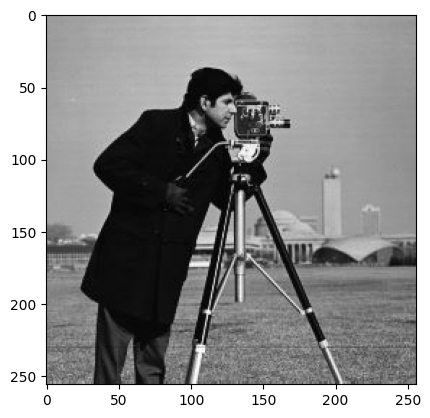

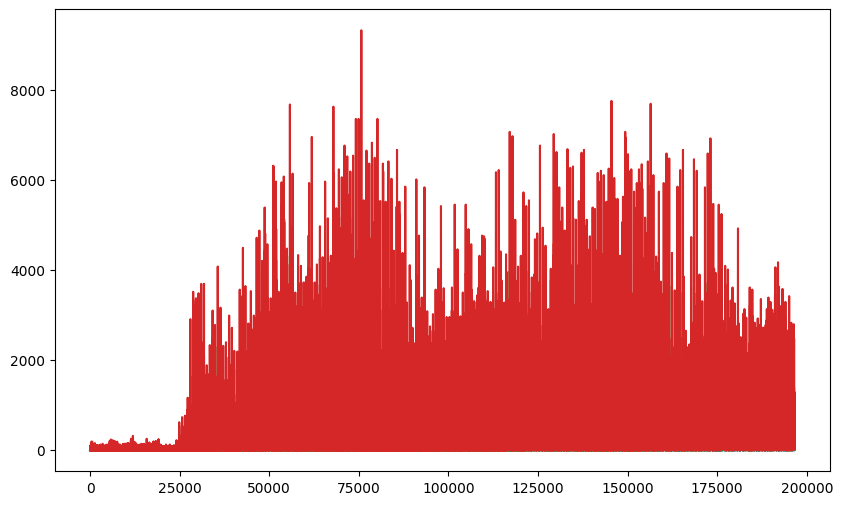

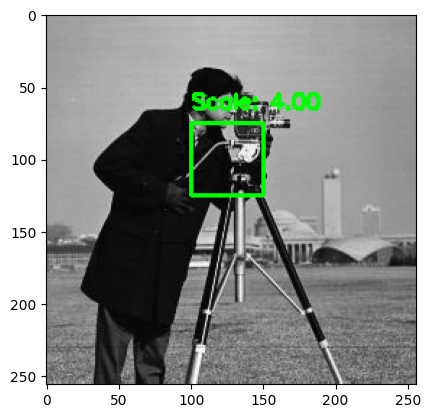

In [47]:
# B) Scale Invariance [30%]

# 1. Load cameraman.jpg and select a feature-rich region.
url = "https://raw.githubusercontent.com/tferdous17/CSC467_Module3Assignment/main/cameraman.jpg"
img = io_url.imread(url)
plt.imshow(img)

x, y, w, h = 100, 75, 50, 50
feature_region = img[y:y+h, x:x+w]

def compute_laplacian(image, sigma):
    # Compute the Laplacian
    laplacian = cv2.Laplacian(img, cv2.CV_64F)

    # Compute the normalized Laplacian
    normalized_laplacian = sigma**2 * np.abs(laplacian)

    return laplacian, normalized_laplacian

# 2. Compute the Laplacian and normalized Laplacian at multiple scales.
scales = [1, 2, 3, 4]
laplacian_responses = []
normalized_laplacian_responses = []

for scale in scales:
    laplacian, normalized_laplacian = compute_laplacian(feature_region, scale)
    laplacian_responses.append(normalized_laplacian)
    normalized_laplacian_responses.append(normalized_laplacian)

# 3. Plot the scale-normalized response over different scales.
plt.figure(figsize=(10,6))
for i, scale in enumerate(scales):
  plt.plot(normalized_laplacian_responses[i].flatten(), label=f'Scale {scale}')

plt.show()

# 4. Display the image with the selected keypoint and the corresponding detected scale.
max_response_index = np.argmax([np.max(res) for res in normalized_laplacian_responses])
selected_sigma = scales[max_response_index]

cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2.putText(img, f'Scale: {selected_sigma:.2f}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()


Text(0.5, 1.0, 'Aligned Image')

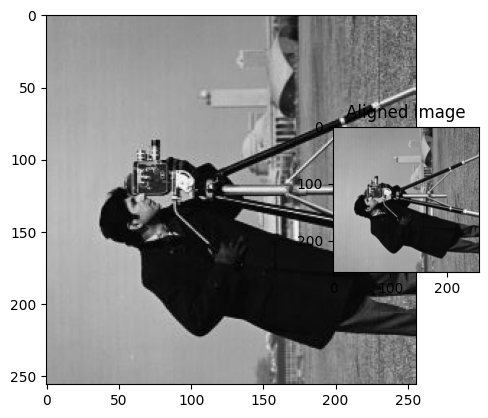

In [54]:
# C) Image Alignment using RANSAC [40%]

url = "https://raw.githubusercontent.com/tferdous17/CSC467_Module3Assignment/main/cameraman.jpg"
img1 = io_url.imread(url)

img2 = np.rot90(img1, k=1)
plt.imshow(img2)

# 1. Extract keypoints and descriptors using OpenCV's SIFT or ORB.
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# 2. Match features between two images using cv2.BFMatcher.
bf = cv2.BFMatcher()
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

# 3. Estimate the transformation matrix using cv2.findHomography with RANSAC.
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# 4. Warp one image to align with the other using cv2.warpPerspective.
aligned_image = cv2.warpPerspective(img1, homography_matrix, (img2.shape[1], img2.shape[0]))

# 5. Display and save the transformed image.
plt.subplot(1, 3, 3)
plt.imshow(aligned_image, cmap='gray')
plt.title("Aligned Image")

# Use cameraman.jpg and another transformed version of it for this task.